### Imports & Standard Procedure

In [200]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# RMSE and R^2 
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split as tts 

# fitting stepwise auto-ARIMA to find optimal p, q, d values 
import pmdarima as pm 
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# RobustScaled features to help model converge
from sklearn.preprocessing import RobustScaler

# surpress warnings
import warnings
warnings.filterwarnings("ignore", message="No supported index is available", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# Show full width of each column
pd.set_option('display.max_colwidth', None)





### Reading Data in
- Merged average values into market_hotness.csv (from hi_filterd_RS.csv)

In [4]:
# Read in new hotness index file with features (from datapipeline2.rmd) -> Hotness index variable
df = pd.read_csv("../Stats 170 Market Hotness/Datasets/hotness_index.csv", low_memory=False)

df.head()

,Unnamed: 0,Year,Month,cntycd,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,weight,adj_avg_salelistratio,adj_med_dom,date,scaled_salelistratio,scaled_dom,raw_hotness,hotness_index
0,1,2020,2,6001,12.5,1.104670,295,1.081750,13.0,0.907692,1.102554,12.546154,2020-02-01,3.924848,0.476011,4.400859,75.477438
1,2,2020,2,6007,14.0,0.955099,199,0.964700,14.0,0.868996,0.956357,14.000000,2020-02-01,-1.013131,0.353719,-0.659412,42.753370
2,3,2020,2,6013,14.0,1.027662,255,1.020982,13.0,0.894737,1.026959,13.894737,2020-02-01,1.371524,0.362574,1.734097,58.231862
3,4,2020,2,6019,22.0,0.957421,13,0.988993,13.0,0.302326,0.979448,15.720930,2020-02-01,-0.233198,0.208961,-0.024237,46.860960
4,5,2020,2,6021,36.5,0.964926,16,0.975615,12.0,0.347826,0.971897,20.521739,2020-02-01,-0.488233,-0.194864,-0.683097,42.600202


In [281]:
# For forecasting on new data 2020-2024 to forecast on 2024
full_df = pd.read_csv('../Stats 170 Market Hotness/Datasets/hotness_index_full.csv') 

# For pure training 
train_df = pd.read_csv('../Stats 170 Market Hotness/Datasets/hotness_index_train.csv')

# For pure testing / validation for forecasting 
test_df = pd.read_csv('../Stats 170 Market Hotness/Datasets/hotness_index_test.csv')

full_df.head()

,Year,Month,cntycd,med_dom,avg_salelistratio,n,med_buildingareatotal,med_yearbuilt,med_FEDFUNDS,med_propertytax,med_unemploymentrate,med_hpi,med_CPI,med_interestRate,prior_salelistratio,prior_dom,weight,adj_avg_salelistratio,adj_med_dom,date,scaled_salelistratio,scaled_dom,raw_hotness,hotness_index
0,2020,2,6001,12.0000,1.1084,737,1340.0000,1966.0000,1.5800,779769928,NaN,669.4100,274.4120,NaN,1.0846,13.0000,0.9609,1.1074,12.0391,2020-02-01,3.8341,0.4350,4.2690,89.6795
1,2020,2,6007,13.0000,0.9607,504,1663.0000,1984.0000,1.5800,27517338,NaN,669.4100,274.4120,NaN,0.9717,13.0000,0.9438,0.9613,13.0000,2020-02-01,-0.7084,0.3682,-0.3403,74.6829
2,2020,2,6013,14.0000,1.0213,697,1712.0000,1987.0000,1.5800,373367933,NaN,669.4100,274.4120,NaN,1.0199,13.0000,0.9587,1.0213,13.9587,2020-02-01,1.1550,0.3015,1.4565,80.5288
3,2020,2,6019,33.0000,0.9666,36,1438.0000,1975.0000,1.5800,170548340,NaN,669.4100,274.4120,NaN,0.9911,13.0000,0.5455,0.9777,23.9091,2020-02-01,-0.1975,-0.3900,-0.5875,73.8785
4,2020,2,6021,36.5000,0.9681,34,1564.0000,1972.5000,1.5800,3891615,NaN,669.4100,274.4120,NaN,0.9794,13.0000,0.5312,0.9734,25.4844,2020-02-01,-0.3319,-0.4995,-0.8315,73.0848


### Fitting SARIMAX Model - For entire dataset (Seasonality cannot be used as not enough datapoints per county)
- Took out the standard median_salelistratio, absorption, and median_dom due to model overfitting/data leakage 
- will need to use lagged features + macroeconomic features
- Considering average and median values (with lag) for model features.






In [285]:
# Define feature columns
exog_cols = ['prior_dom',
             'prior_salelistratio',
             #'med_yearbuilt', 
             'med_buildingareatotal',
             #'med_FEDFUNDS', 
             #'med_propertytax', 
             'med_hpi', 
             #'med_CPI',
             #'med_unemploymentrate',  - temporary not using this - fixing NaN issues
             #'med_totalRevenues',
             #'med_estimatedPopulation', 'med_revenuePerCapita'
             ]

# New features to test 
# Features associated with the property: 'adj_avg_salelistratio', 'adj_med_dom', 'yearbuilt', 'buildingareatotal', 'Family_Type',
# Federal/macroeconomic features : 'FEDFUNDS', 'property_tax', 'unemployment_rate', 'hpi', 'CPI', 'Total.Revenues',
# 'Estimated.Population', 'Revenues.Per.Capita', 'interest_rate'

# Avoiding the use of med_interestRate since its NaN

# Set up Train - Test - Split

dfs_x = train_df.copy()
dfs_y = test_df.copy()

# Ensure 'date' is datetime
dfs_x['date'] = pd.to_datetime(dfs_x['date'])
dfs_y['date'] = pd.to_datetime(dfs_y['date'])

# Set date as index (optional)
dfs_x.set_index('date', inplace=True)
dfs_y.set_index('date', inplace=True)


for col in [exog_cols]:
    
    # Try filling with county-level median
    dfs_x[col] = dfs_x.groupby('cntycd')[col].transform(
        lambda x: x.fillna(x.median())
    )
    
    # Fill any remaining NaNs (where county median was not available) with global median
    dfs_x[col] = dfs_x[col].fillna(dfs_x[col].median())
    
    # Try filling with county-level median
    dfs_y[col] = dfs_y.groupby('cntycd')[col].transform(
        lambda x: x.fillna(x.median())
    )
    
    # Fill any remaining NaNs (where county median was not available) with global median
    dfs_y[col] = dfs_y[col].fillna(dfs_y[col].median())

# Filter to Feb 2, 2020 – Feb 2, 2025

# No need to filter date anymore as we have separate train and test dataframes. 

# train test split 

train = dfs_x
test = dfs_y



In [286]:
# Filter to Feb 2, 2020 – Feb 2, 2025

med_subset = ['med_yearbuilt', 'med_buildingareatotal',
             'med_FEDFUNDS', 'med_propertytax', 'med_hpi', 'med_CPI']

# Scale exogenous features
#scaler = RobustScaler()
#dfs_x[med_subset] = scaler.fit_transform(dfs_x[med_subset])
#dfs_y[med_subset] = scaler.fit_transform(dfs_y[med_subset])

# train test split 

# Endogenous and exogenous variables 
y_train = train['hotness_index']
X_train = train[exog_cols]


y_test = test['hotness_index']
X_test = test[exog_cols]

In [287]:
train_start = train.index.min()
train_end = train.index.max()
test_start = test.index.min()
test_end = test.index.max()

print(f"Train range: {train_start} to {train_end}")
print(f"Test range:  {test_start} to {test_end}")

Train range: 2020-02-01 00:00:00 to 2024-08-01 00:00:00
Test range:  2024-09-01 00:00:00 to 2024-12-01 00:00:00


In [288]:
# fit arimax model 
model = SARIMAX(y_train, exog=X_train, order=(0, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False, maxiter=2000)
print(results.summary())

# Step 1: Run forecast
forecast = results.get_forecast(steps=len(test), exog=X_test)

# Step 2: Manually align prediction to test index
predicted = pd.Series(forecast.predicted_mean.values, index=test.index)

# Step 3: Combine actual and predicted
eval_df = pd.DataFrame({
    'hotness_index': test['hotness_index'],
    'fitted': predicted
}).dropna()


rmse = root_mean_squared_error(eval_df['hotness_index'], eval_df['fitted'])
r2 = r2_score(eval_df['hotness_index'], eval_df['fitted'])

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")



                               SARIMAX Results                                
Dep. Variable:          hotness_index   No. Observations:                 2398
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -5841.483
Date:                Sun, 08 Jun 2025   AIC                          11694.967
Time:                        18:36:18   BIC                          11729.653
Sample:                             0   HQIC                         11707.587
                               - 2398                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
prior_dom                -0.2100      0.005    -39.623      0.000      -0.220      -0.200
prior_salelistratio     104.0512      2.253     46.181      0.000      99.635     108.467
med_buil

Order = (1, 1, 1)
- Test RMSE: 4.0377
- Test R²:   -0.1029

Order = (0, 1, 1)
Test RMSE: 3.7755
Test R²:   0.0357



### Sanity check for any NaN variables

In [280]:
print(X_train.isnull().sum())  # Shows which columns have NaNs

prior_dom                0
prior_salelistratio      0
med_yearbuilt            0
med_buildingareatotal    0
med_FEDFUNDS             0
med_propertytax          0
med_hpi                  0
med_CPI                  0
dtype: int64


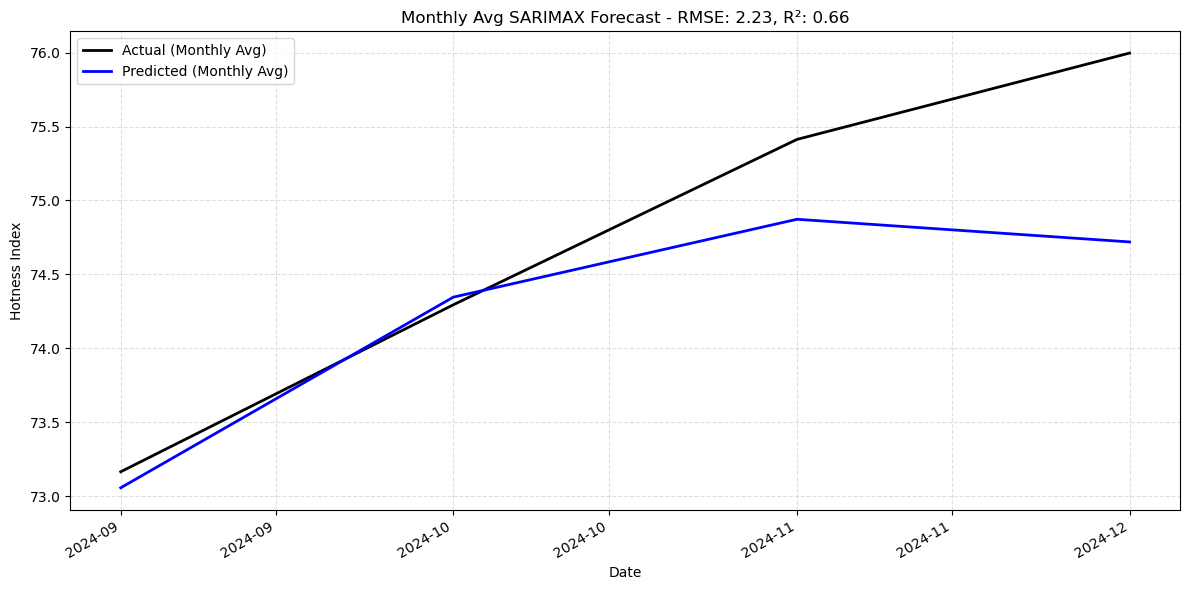

In [290]:
eval_df = eval_df.copy()
eval_df['month'] = eval_df.index.to_period('M').to_timestamp()

monthly_avg = eval_df.groupby('month')[['hotness_index', 'fitted']].mean()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg['hotness_index'], label='Actual (Monthly Avg)', color='black', linewidth=2)
plt.plot(monthly_avg.index, monthly_avg['fitted'], label='Predicted (Monthly Avg)', color='blue', linewidth=2)

plt.title(f'Monthly Avg SARIMAX Forecast - RMSE: {rmse:.2f}, R²: {r2:.2f}')
plt.xlabel('Date')
plt.ylabel('Hotness Index')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()
